In [1]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
import os
import vectorbt as vbt
import io
import sys
from contextlib import redirect_stdout
from datetime import datetime
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().absolute().parent
sys.path.append(str(project_root))

# Import utils with different aliases
from src.utils import csv_exporter as csv_utils
from src.utils import validation as val_utils
from src.utils import transformations as trans_utils
from src.utils import data_merger as merge_utils
from src.utils import config_validator as config_utils
from src.utils import metrics as metric_utils
from src.core.bloomberg_fetcher import fetch_bloomberg_data
from src.utils.transformations import get_ohlc



In [2]:
# Getting all the data 
mapping = {
    ('I05510CA Index', 'INDEX_OAS_TSY_BP'): 'cad_oas',
    ('LF98TRUU Index', 'INDEX_OAS_TSY_BP'): 'us_hy_oas',
    ('LUACTRUU Index', 'INDEX_OAS_TSY_BP'): 'us_ig_oas',
    ('SPTSX Index', 'PX_LAST'): 'tsx',
    ('VIX Index', 'PX_LAST'): 'vix',
}

# Calculate dates
end_date = datetime.now().strftime('%Y-%m-%d')
start_date ='2002-01-01'

# Fetch the data
df = fetch_bloomberg_data(
    mapping=mapping,
    start_date=start_date,
    end_date=end_date,
    periodicity='D',
    align_start=True
).dropna()

# Getting all the er_ytd data 
mapping1 = {
    ('I05510CA Index', 'INDEX_EXCESS_RETURN_YTD'): 'cad_ig_er',
    ('LF98TRUU Index', 'INDEX_EXCESS_RETURN_YTD'): 'us_hy_er',
    ('LUACTRUU Index', 'INDEX_EXCESS_RETURN_YTD'): 'us_ig_er',
}

# Fetch the er_ytd_data
df1 = fetch_bloomberg_data(
    mapping=mapping1,
    start_date=start_date,
    end_date=end_date,
    periodicity='D',
    align_start=True
).dropna()

# Convert er_ytd data to an index
df2 = trans_utils.convert_er_ytd_to_index(df1[['cad_ig_er','us_hy_er','us_ig_er']])
final_df = merge_utils.merge_dfs(df, df2, fill='ffill', start_date_align='yes')

# Handle bad data point for cad_oas on Nov 15 2005
bad_date = '2005-11-15'
if bad_date in final_df.index:
    final_df.loc[bad_date, 'cad_oas'] = final_df.loc[final_df.index < bad_date, 'cad_oas'].iloc[-1]



# Show basic info about the final dataset
print("\nFinal Dataset Info:")
print("=" * 80)
final_df.info()


Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5745 entries, 2002-10-01 to 2025-01-31
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cad_oas          5745 non-null   float64
 1   us_hy_oas        5745 non-null   float64
 2   us_ig_oas        5745 non-null   float64
 3   tsx              5745 non-null   float64
 4   vix              5745 non-null   float64
 5   cad_ig_er_index  5745 non-null   float64
 6   us_hy_er_index   5745 non-null   float64
 7   us_ig_er_index   5745 non-null   float64
dtypes: float64(8)
memory usage: 533.0 KB


# Timing Strategy for `cad_ig_er_index` Using Deep Learning with PyTorch

This notebook builds a deep learning–based timing strategy for the `cad_ig_er_index` series from your pre-set `final_df`. The goal is to predict whether the cumulative future return (over a chosen horizon) is positive. A prediction of "1" means the model is in the market; "0" means remain in cash. Here, we use PyTorch (instead of TensorFlow) to construct and train an LSTM model that uses the other columns as features.

The notebook is divided into the following steps:
1. Data Preprocessing & Setup
2. Feature Engineering & Label Construction
3. Constructing Sliding Windows for LSTM Input
4. Data Scaling & Chronological Splitting
5. Building & Training the LSTM Model in PyTorch
6. Model Evaluation & Advanced Backtesting
7. Surrogate Model for Interpretability (Decision Tree + SHAP)
8. (Optional) Walk-Forward Validation
9. Saving the Final Model Configuration


### Cell 2 – Data Preprocessing & Setup (Code)

In [4]:
#%% Step 1: Data Preprocessing & Setup
# Assumes final_df is already loaded in memory.
import numpy as np
import pandas as pd

# Ensure final_df has a DateTimeIndex and sort it
if not isinstance(final_df.index, pd.DatetimeIndex):
    final_df.index = pd.to_datetime(final_df.index)
final_df.sort_index(inplace=True)
print("Final dataset date range:", final_df.index.min(), "to", final_df.index.max())

# Check that expected columns are present
expected_columns = ['cad_oas', 'us_hy_oas', 'us_ig_oas', 'tsx', 'vix', 
                    'cad_ig_er_index', 'us_hy_er_index', 'us_ig_er_index']
missing = [col for col in expected_columns if col not in final_df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")


Final dataset date range: 2002-10-01 00:00:00 to 2025-01-31 00:00:00


### Cell 3 – Feature Engineering & Label Construction (Code)

In [5]:
#%% Step 2: Feature Engineering & Label Construction
# Compute daily returns for cad_ig_er_index and label future performance.
final_df['target_return'] = final_df['cad_ig_er_index'].pct_change()

# Define a prediction horizon (e.g., 5 days)
horizon = 5

# Define cumulative return function
def cum_return(series):
    return np.prod(1 + series) - 1

# Compute cumulative future return and shift so label precedes the window
final_df['cum_future_return'] = final_df['target_return'].rolling(window=horizon).apply(cum_return, raw=True).shift(-horizon)
final_df.dropna(inplace=True)
final_df['Signal'] = (final_df['cum_future_return'] > 0).astype(int)

# Choose feature columns (exclude cad_ig_er_index itself)
feature_cols = ['cad_oas', 'us_hy_oas', 'us_ig_oas', 'tsx', 'vix', 
                'us_hy_er_index', 'us_ig_er_index']
data = final_df[feature_cols + ['Signal']].copy()
data.reset_index(drop=True, inplace=True)
print("Data shape after feature engineering:", data.shape)


Data shape after feature engineering: (5739, 8)


### Cell 4 – Construct Sliding Windows for LSTM

In [6]:
#%% Step 3: Construct Sliding Windows for LSTM Input
# Create sliding windows of a fixed length (e.g., 10 days) aligned with the future label.
timesteps = 10

X_list, y_list = [], []
for i in range(len(data) - timesteps - horizon + 1):
    X_window = data.loc[i:i+timesteps-1, feature_cols].values
    y_val = data.loc[i+timesteps+horizon-1, 'Signal']
    X_list.append(X_window)
    y_list.append(y_val)

X = np.array(X_list)  # shape: (samples, timesteps, features)
y = np.array(y_list)
print("Sliding window features shape:", X.shape)
print("Sliding window labels shape:", y.shape)


Sliding window features shape: (5725, 10, 7)
Sliding window labels shape: (5725,)


### Cell 5 – Data Scaling & Chronological Splitting

In [7]:
#%% Step 4: Data Scaling & Chronological Splitting
from sklearn.preprocessing import MinMaxScaler

n_samples, t_steps, n_features = X.shape
scaler = MinMaxScaler(feature_range=(0, 1))
X_reshaped = X.reshape(-1, n_features)
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(n_samples, t_steps, n_features)

# Chronological split: 70% train, 15% validation, 15% test.
train_end = int(0.70 * n_samples)
val_end = int(0.85 * n_samples)
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]
print(f"Data split: {X_train.shape[0]} train, {X_val.shape[0]} validation, {X_test.shape[0]} test samples.")


Data split: 4007 train, 859 validation, 859 test samples.


### Cell 6 – Building & Training the LSTM Model in PyTorch

LSTMClassifier(
  (lstm1): LSTM(7, 50, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(50, 30, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1/50 -- Train Loss: 0.6813 | Val Loss: 0.6335
Epoch 2/50 -- Train Loss: 0.6753 | Val Loss: 0.6352
Epoch 3/50 -- Train Loss: 0.6734 | Val Loss: 0.6355
Epoch 4/50 -- Train Loss: 0.6734 | Val Loss: 0.6366
Epoch 5/50 -- Train Loss: 0.6724 | Val Loss: 0.6366
Epoch 6/50 -- Train Loss: 0.6718 | Val Loss: 0.6362
Early stopping triggered.


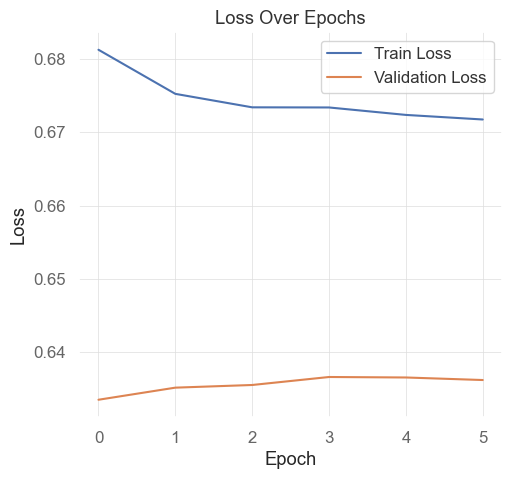

In [8]:
#%% Step 5: Build & Train the LSTM Model in PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Define a custom Dataset for our time series data
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape: (samples, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM-based model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1=50, hidden_size2=30, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True, bidirectional=False)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        # Take the last time step output
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pt = LSTMClassifier(input_size=n_features).to(device)
print(model_pt)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_pt.parameters(), lr=1e-3)

# Training loop with early stopping
num_epochs = 50
patience = 5
best_val_loss = np.inf
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_pt.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_pt(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model_pt.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_pt(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    
    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model_pt.state_dict(), "best_model_pt.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# (Optional) You can compute accuracy on train/val as well.


### Cell 7 – Evaluate Model & Advanced Backtesting

Test Loss: 0.6475 | Test Accuracy: 0.6496


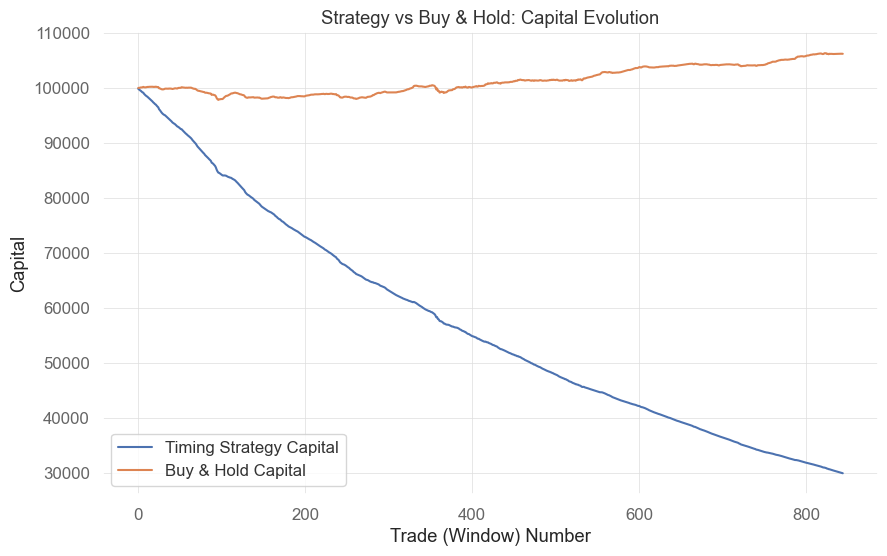

In [10]:
#%% Step 6: Evaluate the PyTorch Model & Advanced Backtesting
# Load the best model state
model_pt.load_state_dict(torch.load("best_model_pt.pth"))
model_pt.eval()

# Evaluate on test set
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_pt(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
test_loss /= len(test_loader.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

# Advanced Backtesting using the PyTorch model predictions.
def backtest_strategy_pytorch(X_windows, model, initial_capital=100000, transaction_cost=0.001, slippage=0.0005, position_size=1.0):
    """
    Simulate trading using model predictions.
    For each window in X_windows, use the model to predict the signal.
    Execute trade if signal == 1, using daily returns from the original cad_ig_er_index series.
    """
    model.eval()
    # Convert X_windows to torch tensor for batch prediction
    X_tensor = torch.tensor(X_windows, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(X_tensor).cpu().numpy().flatten()
    signals = (preds > 0.5).astype(int)
    
    # Align the test windows with original dates (approximate)
    test_start_index = len(data) - len(X_windows)
    original_dates = final_df.iloc[test_start_index + timesteps + horizon - 1:].index
    price_series = final_df['cad_ig_er_index'].loc[original_dates]
    daily_returns = price_series.pct_change().fillna(0).values
    
    # Ensure both signals and daily_returns have the same length
    n = min(len(signals), len(daily_returns))
    signals = signals[:n]
    daily_returns = daily_returns[:n]
    
    capital = initial_capital
    capital_history = []
    trades = []
    for i, signal in enumerate(signals):
        ret = daily_returns[i]
        if signal == 1:
            position = capital * position_size
            entry_cost = position * (transaction_cost + slippage)
            position -= entry_cost
            profit = position * ret
            exit_cost = position * (transaction_cost + slippage)
            capital = capital + profit - exit_cost
            trades.append({'index': i, 'signal': 1, 'return': ret, 'profit': profit, 'capital': capital})
        else:
            trades.append({'index': i, 'signal': 0, 'return': ret, 'profit': 0, 'capital': capital})
        capital_history.append(capital)
    
    buy_hold_cum_return = np.cumprod(1 + daily_returns)
    strategy_cum_capital = np.array(capital_history)
    
    return strategy_cum_capital, buy_hold_cum_return, trades


# Run backtest on test set windows using the PyTorch model
strategy_capital, buy_hold_capital, trade_details = backtest_strategy_pytorch(X_test, model_pt)
plt.figure(figsize=(10,6))
plt.plot(strategy_capital, label='Timing Strategy Capital')
plt.plot(buy_hold_capital * 100000, label='Buy & Hold Capital')
plt.title("Strategy vs Buy & Hold: Capital Evolution")
plt.xlabel("Trade (Window) Number")
plt.ylabel("Capital")
plt.legend()
plt.show()


### Cell 8 – Surrogate Model for Interpretability


Extracted Trading Rules from Surrogate Decision Tree:
Decision_Tree_Rules:
  |--- class: 0



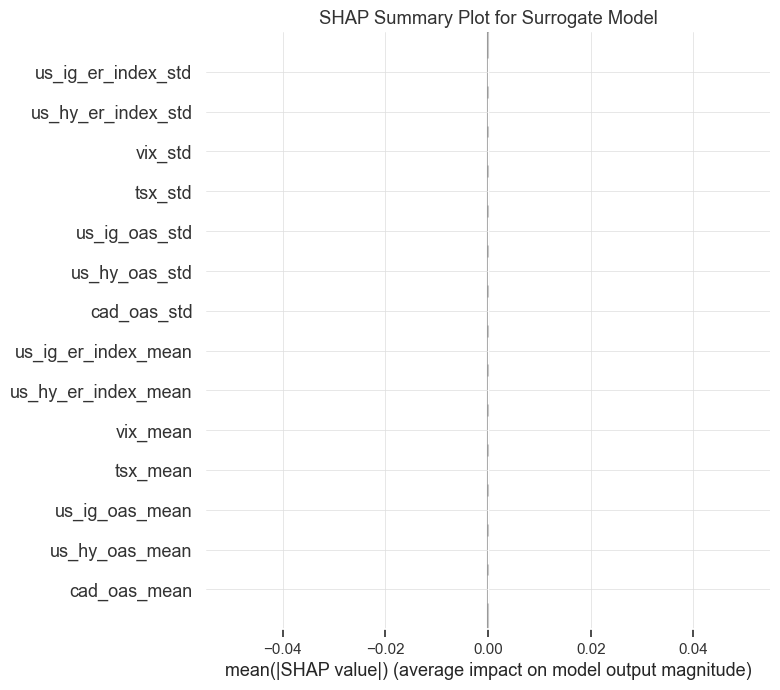

In [13]:
#%% Step 7: Surrogate Model for Interpretability (Decision Tree + SHAP)
from sklearn.tree import DecisionTreeClassifier, export_text
import shap

def compute_summary_stats(X_windows):
    summaries = []
    for sample in X_windows:
        means = np.mean(sample, axis=0)
        stds = np.std(sample, axis=0)
        summaries.append(np.concatenate([means, stds]))
    return np.array(summaries)

X_summary_train = compute_summary_stats(X_train)
# Use the PyTorch model to get probabilities on training set windows
model_pt.eval()
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_prob_train = model_pt(X_train_tensor).cpu().numpy().flatten()
tree_target = (y_prob_train > 0.5).astype(int)

tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_summary_train, tree_target)
feature_names = [f"{col}_mean" for col in feature_cols] + [f"{col}_std" for col in feature_cols]
tree_rules = export_text(tree_model, feature_names=feature_names)
print("\nExtracted Trading Rules from Surrogate Decision Tree:")
def recursive_print(obj, indent=0):
    spacing = "  " * indent
    if isinstance(obj, dict):
        for key, value in obj.items():
            print(f"{spacing}{key}:")
            recursive_print(value, indent+1)
    elif isinstance(obj, list):
        for i, item in enumerate(obj):
            print(f"{spacing}[{i}]:")
            recursive_print(item, indent+1)
    else:
        print(f"{spacing}{obj}")
recursive_print({'Decision_Tree_Rules': tree_rules})

# Create the explainer
explainer = shap.TreeExplainer(tree_model)

# Get SHAP values - we'll get them for all classes
shap_values = explainer.shap_values(X_summary_train)

# Create a new figure
plt.figure(figsize=(10, 6))
plt.title("SHAP Summary Plot for Surrogate Model")

# If we have binary classification (2 classes)
if isinstance(shap_values, list) and len(shap_values) == 2:
    # Use the class 1 (positive class) SHAP values
    shap.summary_plot(
        shap_values[1] if isinstance(shap_values, list) else shap_values,
        X_summary_train,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
else:
    # For single output or multi-class cases
    shap.summary_plot(
        shap_values,
        X_summary_train,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )

plt.tight_layout()
plt.show()

### Cell 9 – Optional: Walk-Forward Validation

In [14]:
#%% Step 8: Optional Walk-Forward Validation
def walk_forward_split(X, y, n_splits=5):
    total = len(X)
    fold_size = total // (n_splits + 1)
    for i in range(1, n_splits+1):
        end_train = i * fold_size
        X_train_wf = X[:end_train]
        y_train_wf = y[:end_train]
        X_val_wf = X[end_train:end_train+fold_size]
        y_val_wf = y[end_train:end_train+fold_size]
        yield X_train_wf, y_train_wf, X_val_wf, y_val_wf

print("\nWalk-Forward Validation Results:")
wf_results = []
for fold, (X_tr, y_tr, X_val_wf, y_val_wf) in enumerate(walk_forward_split(X, y, n_splits=5), 1):
    print(f"\nFold {fold}: Train samples: {len(X_tr)}, Validation samples: {len(X_val_wf)}")
    # Build a new PyTorch model for each fold.
    wf_model = LSTMClassifier(n_features).to(device)
    wf_optimizer = torch.optim.Adam(wf_model.parameters(), lr=1e-3)
    wf_criterion = nn.BCELoss()
    
    # Create datasets and loaders
    wf_train_dataset = TimeSeriesDataset(X_tr, y_tr)
    wf_val_dataset = TimeSeriesDataset(X_val_wf, y_val_wf)
    wf_train_loader = DataLoader(wf_train_dataset, batch_size=32, shuffle=False)
    wf_val_loader = DataLoader(wf_val_dataset, batch_size=32, shuffle=False)
    
    best_val_loss = np.inf
    patience_counter = 0
    for epoch in range(20):
        wf_model.train()
        running_loss = 0.0
        for inputs, targets in wf_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            wf_optimizer.zero_grad()
            outputs = wf_model(inputs)
            loss = wf_criterion(outputs, targets)
            loss.backward()
            wf_optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / len(wf_train_loader.dataset)
        
        # Validation
        wf_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in wf_val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = wf_model(inputs)
                loss = wf_criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        epoch_val_loss = val_loss / len(wf_val_loader.dataset)
        print(f"Fold {fold} Epoch {epoch+1} -- Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 3:
                break
    # Evaluate fold
    wf_model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in wf_val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = wf_model(inputs)
            loss = wf_criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    fold_loss = total_loss / len(wf_val_loader.dataset)
    print(f"Fold {fold} evaluation loss: {fold_loss:.4f}")
    wf_results.append(fold_loss)



Walk-Forward Validation Results:

Fold 1: Train samples: 954, Validation samples: 954
Fold 1 Epoch 1 -- Train Loss: 0.6829 | Val Loss: 0.6874
Fold 1 Epoch 2 -- Train Loss: 0.6765 | Val Loss: 0.6896
Fold 1 Epoch 3 -- Train Loss: 0.6749 | Val Loss: 0.6898
Fold 1 Epoch 4 -- Train Loss: 0.6739 | Val Loss: 0.6904
Fold 1 evaluation loss: 0.6904

Fold 2: Train samples: 1908, Validation samples: 954
Fold 2 Epoch 1 -- Train Loss: 0.6923 | Val Loss: 0.6749
Fold 2 Epoch 2 -- Train Loss: 0.6869 | Val Loss: 0.6705
Fold 2 Epoch 3 -- Train Loss: 0.6854 | Val Loss: 0.6685
Fold 2 Epoch 4 -- Train Loss: 0.6849 | Val Loss: 0.6675
Fold 2 Epoch 5 -- Train Loss: 0.6845 | Val Loss: 0.6668
Fold 2 Epoch 6 -- Train Loss: 0.6839 | Val Loss: 0.6662
Fold 2 Epoch 7 -- Train Loss: 0.6830 | Val Loss: 0.6655
Fold 2 Epoch 8 -- Train Loss: 0.6831 | Val Loss: 0.6654
Fold 2 Epoch 9 -- Train Loss: 0.6824 | Val Loss: 0.6649
Fold 2 Epoch 10 -- Train Loss: 0.6831 | Val Loss: 0.6652
Fold 2 Epoch 11 -- Train Loss: 0.6834 | Val